Face to Emoji를 만들건데 노트북 웹캠을 통해 개발하고 깃에 올려 스마트폰에서 사용할 수 있게 할 것이다.

## Pre-requisite
```
pip install tensorflowjs
```
* Tensorflow.js -> MobileNet
* Facial Expression dataset

## Environment
#### directory architecture
```
.../tfjs_mobile/model
.../tfjs_mobile/data
```

#### HTML 편집기
`gedit index.html`을 통해 작업 디렉터리 아래에 index.html 파일을 생성하고 편집하는 편집기를 실행할 수 있다.

#### Deploy
Gihub pages(github.io)를 통해 배포한다.

### 파이썬 로컬 웹서버 띄우기
```
python3 -m http.server 8080
```
HTML 문서를 만든 디렉터리로 이동한 후, 이 명령어를 실행하면 파이썬에 기본으로 내장된 HTTP 서버를 실행할 수 있다.

### Tensorflow.js
Tensorflow의 장점 중 하나는 다양한 서비스 플랫폼을 지원한다는 점이다. 파이썬 외에도 C++, Java 등 주요 언어별 Tensorflow API를 제공한다.
* Tensorflow Lite : 라즈베리파이 등 임베디드 기기에서 작동
* Tensorflow.js : 웹에서 자바스크립트 기반으로 동작
* Tensorflow mobile

Tensorflow.js의 장점
* 서버에 별도로 요청을 보낼 필요 없이 웹 브라우저 내에서 WebGL을 통해 가속된 추론을 할 수 있음.
* 낮은 지연성(latency) : 웹 브라우저에서 실행하면 별도로 서버에 인풋 파일을 보내고, 서버에서 머신러닝 모델과 서버 로직을 실행한 뒤 서버에서 출력값을 받는 등의 서버 통신 로직을 생략하기 때문
* 언어 특성상 웹개발에 적합하므로 빠른 프로토타입 개발에 용이

Tensorflow.js의 단점
* 웹 브라우저 내에서 작동하는 어플리케이션의 경우 운영체제에서 직접 작동하는 프로그램보다 연산 자원이 제한된다는 단점이 있다. 따라서 복잡하고 무거운 모델의 경우 tfjs보다는 서버에서 추론한 결과값만 전달받는 방식이 더 적합.

[TensorFlow.js 공식 웹사이트](https://www.tensorflow.org/js/models)에 가면 object detection, pose estimation, speech command recognition 등 기본으로 제공되는 모델들이 몇 가지 있음을 발견할 수 있다. 이 중 image classification용으로 제공되는 `ImageNet` 데이터를 학습한 `MobileNet`을 사용할 예정.
* [MobileNet Github](https://github.com/tensorflow/tfjs-models/tree/master/mobilenet)

Tensorflow.js를 html에서 사용하기 위해서는 다음 코드를 </ title> 태그 아래에 추가하면 된다.
```
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@1.0.1"></script>
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset 준비
캐글의 Facial Expression 데이터 `fer2013.csv`
* 파이썬으로 파일을 열어서 데이터를 읽고 정리한다. 
* PrivateTest만 evaluation 데이터로 사용하고, 나머지는 학습 데이터로 사용할것임. 
* 3.5만행이나 되니 tqdm을 써서 for 루프의 진척도를 표시.
* 캐글에 Training, PublicTest, PrivateTest 세 가지로 데이터 분할을 명시해둠. 여기서 PrivateTest만 evaluation 데이터로 사용하고 나머지는 학습 데이터로 사용하자.

In [3]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = '/content/drive/MyDrive/Colab Notebooks/data/fer2013.csv'

with open(csv_path) as f:
    for line in tqdm.tqdm(f.read().splitlines()[1:]):
        emotion, pixels, usage = line.split(',')
    
        x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
        y = int(emotion)

        if usage == 'PrivateTest':
            eval_x.append(x)
            eval_y.append(y)
        else:
            train_x.append(x)
            train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:33<00:00, 1071.78it/s]


train : 32298, eval :3589


Angry


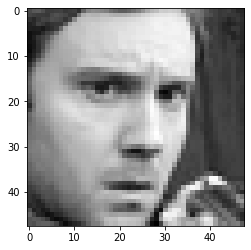

In [4]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

Happy


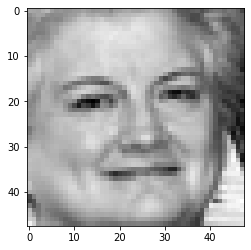

In [5]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[100]])
plt.imshow(train_x[100].reshape([48, 48]), cmap='gray')

## MobileNet 모델 학습하기
Keras에 MobileNet V2가 제공되고 있으므로 그걸 쓴다.
* 입력 차원과 클래스 개수 내 데이터셋에 맞추기
* 우선 100 epoch만 학습하여 모델이 정상동작하는지 확인

In [8]:
import tensorflow as tf

# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=100,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)))

Epoch 1/100
64/64 [==============================] - 12s 134ms/step - loss: 1.8948 - categorical_accuracy: 0.2202 - val_loss: 1.9297 - val_categorical_accuracy: 0.2449
Epoch 2/100
64/64 [==============================] - 8s 123ms/step - loss: 1.7122 - categorical_accuracy: 0.3080 - val_loss: 1.9232 - val_categorical_accuracy: 0.2449
Epoch 3/100
64/64 [==============================] - 8s 124ms/step - loss: 1.6170 - categorical_accuracy: 0.3652 - val_loss: 1.9219 - val_categorical_accuracy: 0.1471
Epoch 4/100
64/64 [==============================] - 8s 125ms/step - loss: 1.5088 - categorical_accuracy: 0.4163 - val_loss: 1.9244 - val_categorical_accuracy: 0.1744
Epoch 5/100
64/64 [==============================] - 8s 125ms/step - loss: 1.4127 - categorical_accuracy: 0.4551 - val_loss: 1.9255 - val_categorical_accuracy: 0.1744
Epoch 6/100
64/64 [==============================] - 8s 125ms/step - loss: 1.3420 - categorical_accuracy: 0.4902 - val_loss: 1.9414 - val_categorical_accuracy: 0.17

In [9]:
model.summary()

Model: "mobilenetv2_1.00_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   288         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 24, 24, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [14]:
model_path = '/content/drive/MyDrive/model2.h5'
model.save(model_path)

## 저장한 모델을 tensorflow.js 형태로 변환
터미널에서 저장한 모델을 `tensorflowjs_converter` 명령어를 사용하여 변환
```
tensorflowjs_converter --input_format=keras model.h5 model
```
* /model 디렉터리에 `model.json` 및 모델 파일들이 생성되었는지 확인한다.

## 카메라에서 가져온 영상 전처리
학습한 데이터는 가로세로 각 48 픽셀의 정사각형 흑백 이미지이다. 따라서 MobilNet의 \<canvas\> 사이즈를 48x48로 변환하고 RGB를 흑백 이미지로 처리해야 함.
* gedit에서 js로 처리
* `<canvas>`의 선언부에서 사이즈를 가로세로 48로 설정하고 grayscale style 부여
* 버튼 클릭시에도 사이즈에 맞게 캡쳐한 이미지를 `<canvas>`에 그려줌.

  ```
  <button>Take snapshot</button>
    <canvas></canvas>
    <script>
      video = document.querySelector('video');
      canvas = document.querySelector('canvas');
      canvas.width = 48;
      canvas.height = 48;
      canvas.style.filter = 'grayscale(1)';
      video.style.transform = 'scaleX(-1)';

    button.onclick = function() {
        w = video.videoWidth;
        h = video.videoHeight;
        s = Math.min(w, h);
        sx = (w-s)/2;
        sy = (h-s)/2;

        canvas.getContext('2d').drawImage(video, sx=sx, sy=sy, swidth=s,
          sheight=s, x=0, y=0, width=48, height=48);
    };
    ```